Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>


## 1. Download and Explore Dataset


Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.


In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.


In [5]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.


In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.


In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.


In [14]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.


In [15]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.


In [16]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [17]:
CLIENT_ID = 'SBPPJXXVK3DNXUMMAEXGNQ5DRZDY5DAPBQB5RS3VDEVBIYAD' # your Foursquare ID
CLIENT_SECRET = 'VD4P01B1EGYSIV3W5ICNTCRO1XQAABP0G1X4FZ0BNXDXKODO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 300


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SBPPJXXVK3DNXUMMAEXGNQ5DRZDY5DAPBQB5RS3VDEVBIYAD
CLIENT_SECRET:VD4P01B1EGYSIV3W5ICNTCRO1XQAABP0G1X4FZ0BNXDXKODO


#### Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.


In [18]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.


In [19]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.


First, let's create the GET request URL. Name your URL **url**.


In [20]:
# type your answer here
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)


Double-click **here** for the solution.

<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 


Send the GET request and examine the resutls


In [21]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6005e2d4ccdb8b3199710aef'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 13,
  'suggestedBounds': {'ne': {'lat': 40.87925078149964,
    'lng': -73.90709546695875},
   'sw': {'lat': 40.87385077609964, 'lng': -73.91422385030087}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-23-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Rite Aid,Pharmacy,40.875467,-73.908906
2,Subway,Sandwich Place,40.874667,-73.909586
3,GameStop,Video Game Store,40.874267,-73.909342
4,CTown Supermarkets,Grocery Store,40.875632,-73.908605


And how many venues were returned by Foursquare?


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

13 venues were returned by Foursquare.


<a id='item2'></a>


## 2. Explore Neighborhoods in Manhattan


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response = requests.get(url).json()
        
        try:
            results = response["response"]['groups'][0]['items']
        except:
            pring(str(response))
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.


In [26]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   radius=700
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [27]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

# make the GET request
categories_response = requests.get(categories_url).json()['response']


In [28]:
def get_category_hierarchy(cat_name, categories):
    for c in categories:
        if c['name'] == cat_name:
            return [c]
        nested = get_category_hierarchy(cat_name, c['categories'])
        if nested:
            nested.insert(0, c)
            return nested
    
    return None
            
    

In [29]:
print(len(manhattan_venues['Venue Category'].unique()))

for i in range(0,manhattan_venues.shape[0]):
    orig_cat = manhattan_venues.loc[i, 'Venue Category']
    try:
        new_cat = get_category_hierarchy(orig_cat, categories_response['categories'])[1]['name']
        manhattan_venues.loc[i, 'Venue Category'] = new_cat
    except:
        print('Failed to find new group for: ' + orig_cat)
        

print(len(manhattan_venues['Venue Category'].unique()))
manhattan_venues.head(20)

331
Failed to find new group for: Shop & Service
Failed to find new group for: Outdoors & Recreation
208


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Athletics & Sports
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
5,Marble Hill,40.876551,-73.91066,Estrellita Poblana V,40.879687,-73.906257,Mexican Restaurant
6,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
7,Marble Hill,40.876551,-73.91066,El Malecon,40.879338,-73.904457,Caribbean Restaurant
8,Marble Hill,40.876551,-73.91066,ALDI,40.877836,-73.904656,Food & Drink Shop
9,Marble Hill,40.876551,-73.91066,Baker Athletic Complex,40.872061,-73.914876,Athletics & Sports


Double-click **here** for the solution.

<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 


#### Let's check the size of the resulting dataframe


In [30]:
print(manhattan_venues.shape)
#manhattan_venues.head()

len(manhattan_venues['Venue Category'].unique())

# create map
# map_venues = folium.Map(location=[40.876844, -73.906204], zoom_start=11)

# for lat, lon in zip(manhattan_venues['Venue Latitude'], manhattan_venues['Venue Longitude']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=3,
#         fill=True,
#         fill_opacity=0.7).add_to(map_venues)
       
# map_venues




(3747, 7)


208

Let's check how many venues were returned for each neighborhood


In [31]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,66,66,66,66,66,66
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,86,86,86,86,86,86
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues


In [32]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 208 uniques categories.


<a id='item3'></a>


## 3. Analyze Each Neighborhood


In [33]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head(20)

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Government Building,Greek Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,Hot Dog Joint,Hotel,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Newsstand,Nightclub,Non-Profit,Office,Optical Shop,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Public Art,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Steakhouse,Supplement Shop,Swiss Restaurant,Tailor Shop,Tattoo Parlor,Tea Room,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Waterfront,Wings Joint
0,Marble Hill,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.


In [34]:
manhattan_onehot.shape

(3747, 209)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [35]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Big Box Store,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Government Building,Greek Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,Hot Dog Joint,Hotel,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Newsstand,Nightclub,Non-Profit,Office,Optical Shop,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Public Art,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Steakhouse,Supplement Shop,Swiss Restaurant,Tailor Shop,Tattoo Parlor,Tea Room,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Waterfront,Wings Joint
0,Battery Park City,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.100000,0.01,0.00,0.00,0.010000,0.000000,0.010000,0.000000,0.030000,0.000000,0.01,0.000000,0.000000,0.00,0.000000,0.010000,0.000000,0.00,0.00,0.00,0.010000,0.00,0.030000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.050000,0.00,0.090000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.010000,0.010000,0.00,0.00,0.000000,0.010000,0.020000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.00,0.00,0.01,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.050000,0.02,0.000000,0.000000,0.010000,0.000000,0.00,0.00,0.010000,0.00,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.060000,0.000000,0.000000,0.00,0.000000,0.02,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.03,0.000000,0.030000,0.000

#### Let's confirm the new size


In [36]:
manhattan_grouped.shape

(40, 209)

#### Find the correlation between categories


In [37]:
target_venue_type = 'Bakery' 

# find other most influencing venues
corr_matrix = manhattan_grouped.corr().abs()
corr_matrix = corr_matrix.sort_values(target_venue_type, ascending=False)

y_indexes = corr_matrix.index.values.tolist()[1:16]
# indexes.insert(0, 'Neighborhood')

# manhattan_grouped_cleaned = manhattan_grouped[indexes]
# manhattan_grouped_cleaned.head(30)

x = manhattan_grouped[y_indexes]
y = manhattan_grouped[[target_venue_type]]

linear_regression = LinearRegression()
linear_regression.fit(x,y)
y_pred = linear_regression.predict(x)

# y_pred
manhattan_scored = manhattan_grouped[['Neighborhood', target_venue_type]]
manhattan_scored['DemandProjected'] = y_pred
manhattan_scored['DemandAdjusted'] = manhattan_scored['DemandProjected'] - manhattan_scored[target_venue_type]
adj_mean = manhattan_scored['DemandAdjusted'].mean()
adj_std = manhattan_scored['DemandAdjusted'].std()
manhattan_scored['DemandAdjustedStd'] = (manhattan_scored['DemandAdjusted'] - adj_mean) / adj_std

manhattan_scored.head(10)
#manhattan_scored['DemandAdjusted'].mean()
#manhattan_scored['DemandAdjusted'].std()

<ipython-input-37-6254ac5c524f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_scored['DemandProjected'] = y_pred
<ipython-input-37-6254ac5c524f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_scored['DemandAdjusted'] = manhattan_scored['DemandProjected'] - manhattan_scored[target_venue_type]
<ipython-input-37-6254ac5c524f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,Neighborhood,Bakery,DemandProjected,DemandAdjusted,DemandAdjustedStd
0,Battery Park City,0.010000,0.016656,6.655586e-03,9.955081e-01
1,Carnegie Hill,0.050000,0.050000,6.938894e-18,9.340955e-16
2,Central Harlem,0.000000,0.010968,1.096802e-02,1.640540e+00
3,Chelsea,0.040000,0.022133,-1.786730e-02,-2.672499e+00
4,Chinatown,0.080000,0.080000,5.551115e-17,8.199283e-15
5,Civic Center,0.010000,0.013861,3.861343e-03,5.775597e-01
6,Clinton,0.030000,0.024571,-5.428892e-03,-8.120256e-01
7,East Harlem,0.069767,0.069767,-4.163336e-17,-6.331092e-15
8,East Village,0.010000,0.015601,5.601290e-03,8.378120e-01
9,Financial District,0.010000,0.011085,1.084882e-03,1.622710e-01


<AxesSubplot:>

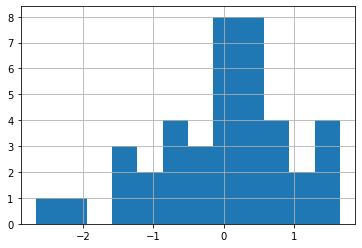

In [38]:
#
manhattan_scored['DemandAdjustedStd'].hist(bins=12)

In [39]:
# let's see at ones that are at least 1 standard deviation high 

In [40]:
manhattan_scored_high_demand = manhattan_scored[manhattan_scored['DemandAdjustedStd'] >= 1]
manhattan_scored_high_demand

,Neighborhood,Bakery,DemandProjected,DemandAdjusted,DemandAdjustedStd
2,Central Harlem,0.00,0.010968,0.010968,1.640540
10,Flatiron,0.01,0.020055,0.010055,1.503930
11,Gramercy,0.00,0.010749,0.010749,1.607726
14,Hudson Yards,0.00,0.011086,0.011086,1.658227
24,Midtown South,0.03,0.037004,0.007004,1.047564


In [41]:
# df1.merge(df2, left_on='lkey', right_on='rkey'

suggestions = manhattan_scored_high_demand.merge(neighborhoods, left_on='Neighborhood', right_on='Neighborhood')
suggestions

,Neighborhood,Bakery,DemandProjected,DemandAdjusted,DemandAdjustedStd,Borough,Latitude,Longitude
0,Central Harlem,0.00,0.010968,0.010968,1.640540,Manhattan,40.815976,-73.943211
1,Flatiron,0.01,0.020055,0.010055,1.503930,Manhattan,40.739673,-73.990947
2,Gramercy,0.00,0.010749,0.010749,1.607726,Manhattan,40.737210,-73.981376
3,Hudson Yards,0.00,0.011086,0.011086,1.658227,Manhattan,40.756658,-74.000111
4,Midtown South,0.03,0.037004,0.007004,1.047564,Manhattan,40.748510,-73.988713


In [42]:
# Display suggested location on the map

In [43]:
# create map of Manhattan using latitude and longitude values
latitude = suggestions.loc[0, 'Latitude']
longitude = suggestions.loc[0, 'Longitude']
map_suggestions = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(suggestions['Latitude'], suggestions['Longitude'], suggestions['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_suggestions)  
    
map_suggestions

#### Let's print each neighborhood along with the top 5 most common venues


#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


Now let's create the new dataframe and display the top 10 venues for each neighborhood.


<a id='item4'></a>


## 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 5 clusters.


Finally, let's visualize the resulting clusters


<a id='item5'></a>


## 5. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.
